In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from covid19_plot_func import plot_state_num, plot_death_cause, plot_death_acc, plot_death_icu_rate
from covid19_prob_parameter import P_matrix
from covid19_model import run_model

from covid19_region_attr import bavaria, lombardy, wuhan, nsw

In [2]:
###########################################
# Choose the region to test the model with
###########################################
# bavaria, lombardy, wuhan, nsw
region = lombardy

n_days = len(region.daily_case) + 50

##### Setting hopsital beds, ICU and ventilator numbers #####

t_hosp_bed = 2000 # Assuming there is enough number of beds

# Set the t_icu number
# Can set it to region.t_icu_est (estimated available ICU avaiable for the region), region.t_icu_ade (adequate ICU number for the region) or any numbers one wants
t_icu = region.t_icu_est

# Initial number of ICU beds. If t_icu_portion is a list, then will run with multiple tests with different t_icu_portion
# t_icu_portion = [1/10, 1/5, 1/2, 1]
# t_icu_portion = np.arange(0.0, 1.01, 0.01)
t_icu_portion = ""


if t_icu_portion !="":
    t_icu = (np.array(t_icu_portion)*t_icu).round()
else:
    t_icu = [t_icu]
t_vent = (np.array(t_icu)*0.6).round() # Initial number of ventilators

############
# Run model
############
list_df_infected = []
list_df_death_cause = []

print("Run model for region: ", region.region_name)
list_df_infected, list_df_death_cause = run_model(region.daily_case, region.pop_ratio, n_days, P_matrix, t_hosp_bed, t_icu, t_vent)

Run model for region:  Lombardy
t_icu:  1174
Running model for Day 0...
Running model for Day 10...
Running model for Day 20...
Running model for Day 30...
Running model for Day 40...
Running model for Day 50...
Running model for Day 60...
Running model for Day 70...
Running model for Day 80...
Running model for Day 90...
Running model for Day 100...
Finished running model for t_icu value of 1174



## Plotting

#### Number of patients in different state plot (plot_state_num)

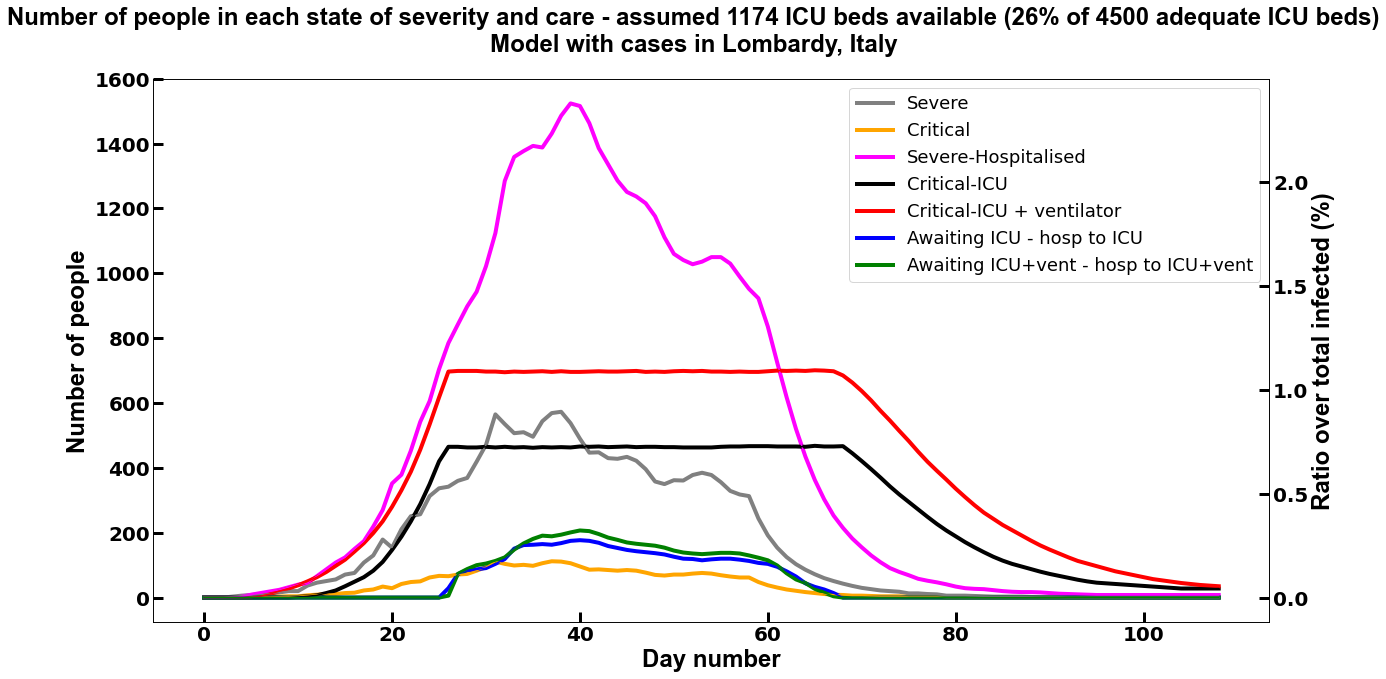

In [3]:
df_infected = list_df_infected[0]
plot_state_num(df_infected, region.daily_case.sum(), region.get_plot_title('plot_state_num', t_icu[0]))

### Number of deaths due to different causes over time

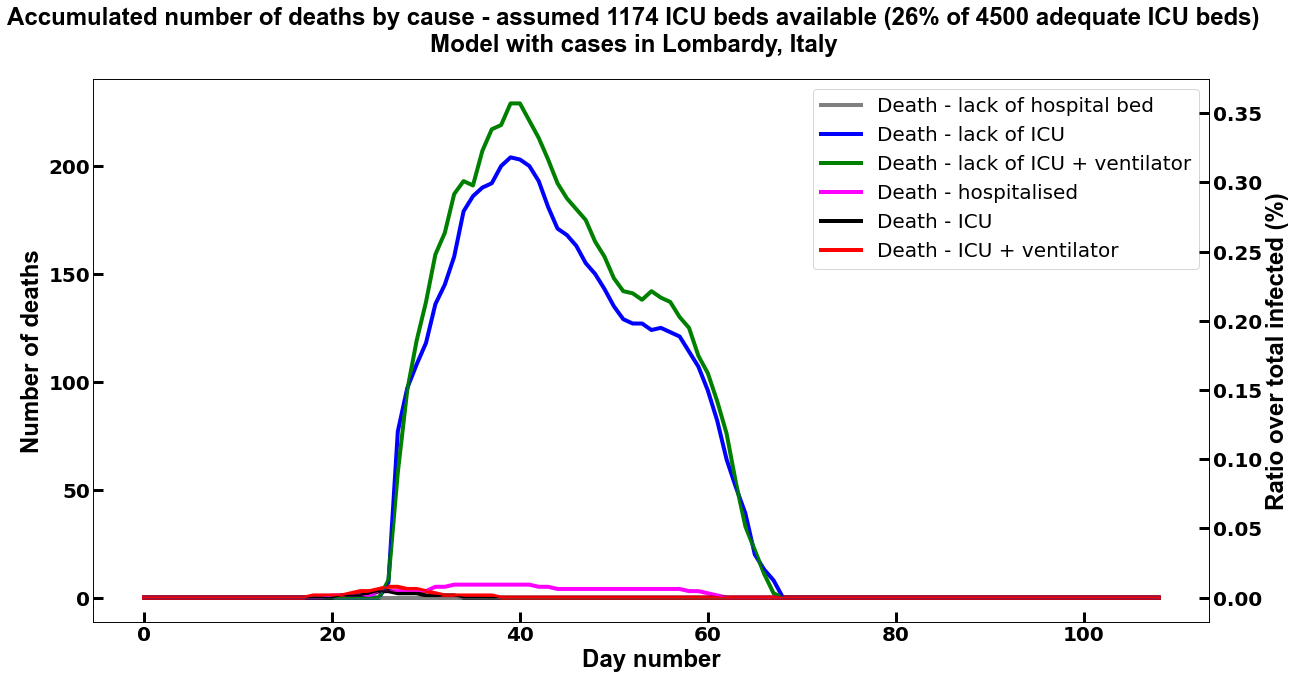

In [4]:
df_death_cause = list_df_death_cause[0]
plot_death_cause(df_death_cause, region.daily_case.sum(), region.get_plot_title('plot_death_acc', t_icu[0]))

### Accumulated number of deaths due to different cuases over time

(<Figure size 1440x720 with 2 Axes>,
 <AxesSubplot:xlabel='Day number', ylabel='Number of deaths'>,
 <AxesSubplot:ylabel='Ratio over total infected (%)'>)

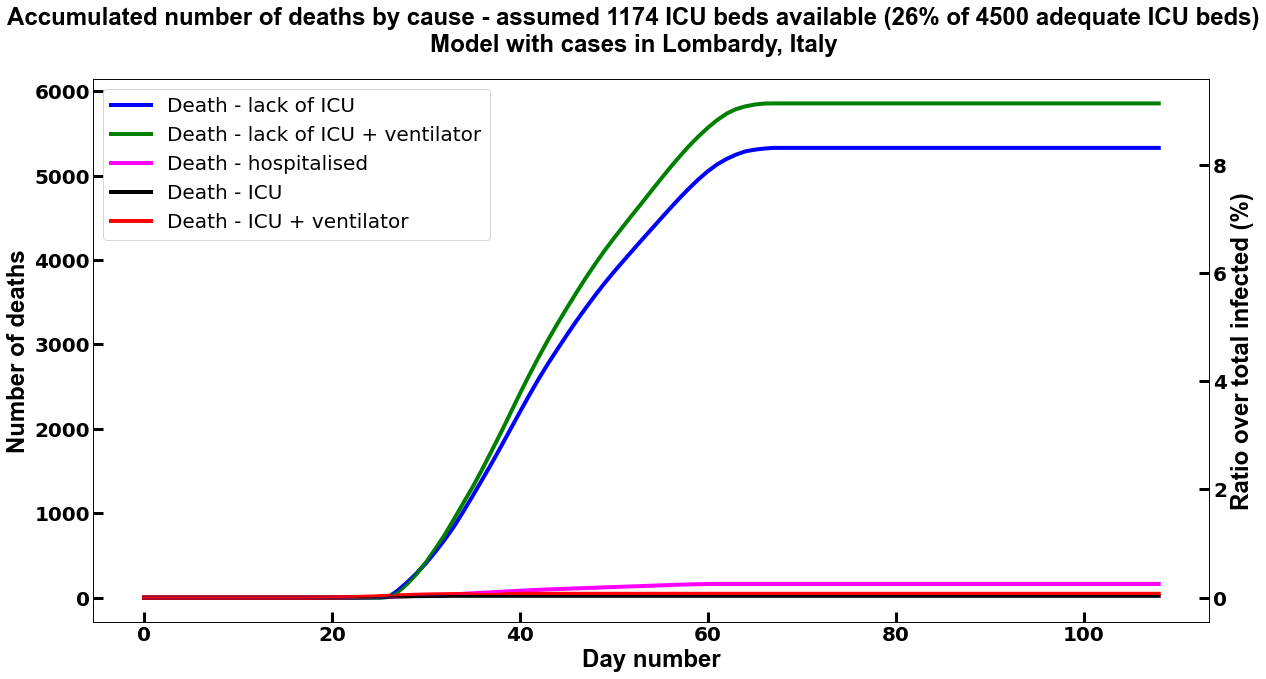

In [5]:
plot_death_acc(df_death_cause, region.daily_case.sum(), region.get_plot_title('plot_death_acc', t_icu[0]))